<a href="https://colab.research.google.com/github/AlexFeeney/Project4_Group3/blob/main/Kmeans_Prac_Himali.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import os
import pandas as pd

!pip install hvplot
import hvplot.pandas

from pathlib import Path
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

#define spark version
spark_version = 'spark-3.5.1'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 14.9 MB/s eta 0:00:00


Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [736 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Hit:8 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,848 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com

In [ ]:
# Start Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Demographics").getOrCreate()

In [ ]:
#Read in the data from the group github repo
from pyspark import SparkFiles
url = "https://raw.githubusercontent.com/AlexFeeney/Project4_Group3/main/Data/healthcare-dataset-stroke-data.csv"
spark.sparkContext.addFile(url)
df = spark.read.csv(SparkFiles.get("healthcare-dataset-stroke-data.csv"), sep=",", header=True)

# Show DataFrame
df.show()

+-----+------+---+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|   id|gender|age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+-----+------+---+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
| 9046|  Male| 67|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|
|51676|Female| 61|           0|            0|         Yes|Self-employed|         Rural|           202.21| N/A|   never smoked|     1|
|31112|  Male| 80|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|
|60182|Female| 49|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|     1|
| 1665|Female| 79|           1|            0|         Yes|Self

In [ ]:
#convert to pandas df
pandas_df = df.toPandas()

In [ ]:
pandas_df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61,0,0,Yes,Self-employed,Rural,202.21,N/A,never smoked,1
2,31112,Male,80,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79,1,0,Yes,Self-employed,Rural,174.12,24,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80,1,0,Yes,Private,Urban,83.75,N/A,never smoked,0
5106,44873,Female,81,0,0,Yes,Self-employed,Urban,125.2,40,never smoked,0
5107,19723,Female,35,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [ ]:
pandas_df.isna()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,False,False,False,False,False,False,False,False,False,False,False,False
5106,False,False,False,False,False,False,False,False,False,False,False,False
5107,False,False,False,False,False,False,False,False,False,False,False,False
5108,False,False,False,False,False,False,False,False,False,False,False,False


In [ ]:
data_without_missing_values = pandas_df.dropna(axis=0)

In [ ]:
data_without_missing_values

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61,0,0,Yes,Self-employed,Rural,202.21,N/A,never smoked,1
2,31112,Male,80,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79,1,0,Yes,Self-employed,Rural,174.12,24,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80,1,0,Yes,Private,Urban,83.75,N/A,never smoked,0
5106,44873,Female,81,0,0,Yes,Self-employed,Urban,125.2,40,never smoked,0
5107,19723,Female,35,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import RobustScaler
rb=RobustScaler()
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as stl
stl.use("ggplot")
import warnings
warnings.filterwarnings("ignore")

In [ ]:
x = data_without_missing_values.drop(['stroke'], axis=1)

In [ ]:
x

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,9046,Male,67,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked
1,51676,Female,61,0,0,Yes,Self-employed,Rural,202.21,N/A,never smoked
2,31112,Male,80,0,1,Yes,Private,Rural,105.92,32.5,never smoked
3,60182,Female,49,0,0,Yes,Private,Urban,171.23,34.4,smokes
4,1665,Female,79,1,0,Yes,Self-employed,Rural,174.12,24,never smoked
...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80,1,0,Yes,Private,Urban,83.75,N/A,never smoked
5106,44873,Female,81,0,0,Yes,Self-employed,Urban,125.2,40,never smoked
5107,19723,Female,35,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked
5108,37544,Male,51,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked


In [ ]:
# Multiple categorical columns
categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

x = pd.get_dummies(x, columns=categorical_cols, dtype=int)

In [ ]:
x

,age,hypertension,heart_disease,avg_glucose_level,gender_Female,gender_Male,gender_Other,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67,0,1,228.69,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0
1,61,0,0,202.21,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0
2,80,0,1,105.92,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0
3,49,0,0,171.23,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1
4,79,1,0,174.12,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,80,1,0,83.75,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0
5106,81,0,0,125.2,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0
5107,35,0,0,82.99,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0
5108,51,0,0,166.29,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0


In [ ]:
#x.drop(['bmi'], axis=1, inplace=True)
x.drop(['id'], axis=1, inplace=True)

In [ ]:
kmeans = KMeans(n_clusters=2, init='k-means++', random_state=42)
kmeans.fit(x)

KMeans(n_clusters=2, random_state=42)

In [ ]:
centroids

array([[4.06949931e+01, 7.34956362e-02, 3.81258613e-02, 8.95165250e+01,
        5.96463023e-01, 4.03307304e-01, 2.29673863e-04, 3.78732200e-01,
        6.21267800e-01, 1.24942582e-01, 4.82315113e-03, 5.69131833e-01,
        1.49058337e-01, 1.52044097e-01, 4.93339458e-01, 5.06660542e-01,
        3.22232430e-01, 1.60082683e-01, 3.64951768e-01, 1.52733119e-01],
       [5.78068783e+01, 2.35449735e-01, 1.45502646e-01, 2.01930794e+02,
        5.25132275e-01, 4.74867725e-01, 1.40946282e-18, 1.42857143e-01,
        8.57142857e-01, 1.49470899e-01, 1.32275132e-03, 5.91269841e-01,
        2.24867725e-01, 3.30687831e-02, 4.84126984e-01, 5.15873016e-01,
        1.86507937e-01, 2.48677249e-01, 4.00793651e-01, 1.64021164e-01]])

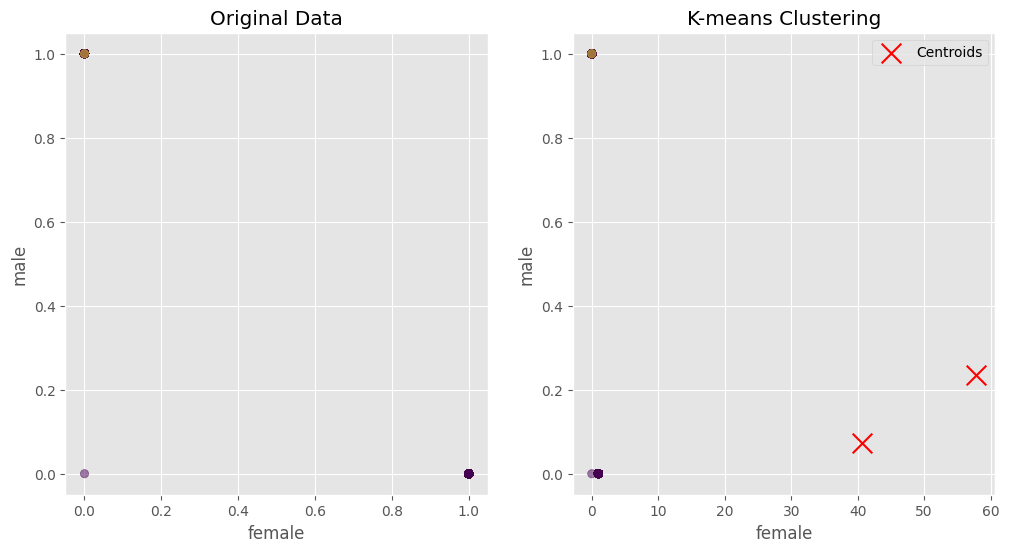

In [ ]:

kmeans = KMeans(n_clusters=2, init='k-means++', random_state=42)
kmeans.fit(x)

# Get cluster centroids and labels
centroids = kmeans.cluster_centers_
labels = kmeans.labels_

# Plot the original data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(x.iloc[:, 4], x.iloc[:, 5], c=labels, cmap='viridis', alpha=0.5)
plt.title('Original Data')
plt.xlabel('female')
plt.ylabel('male')

# Plot the clustered data with centroids
plt.subplot(1, 2, 2)
plt.scatter(x.iloc[:, 4], x.iloc[:, 5], c=labels, cmap='viridis', alpha=0.5)
plt.scatter(centroids[:,0], centroids[:, 1], marker='x', c='red', s=200, label='Centroids')
plt.title('K-means Clustering')
plt.xlabel('female')
plt.ylabel('male')
plt.legend()
plt.show()

In [ ]:
labels

array([1, 1, 0, ..., 0, 1, 0], dtype=int32)

If we had more cloasses to explore, we could do something like this...

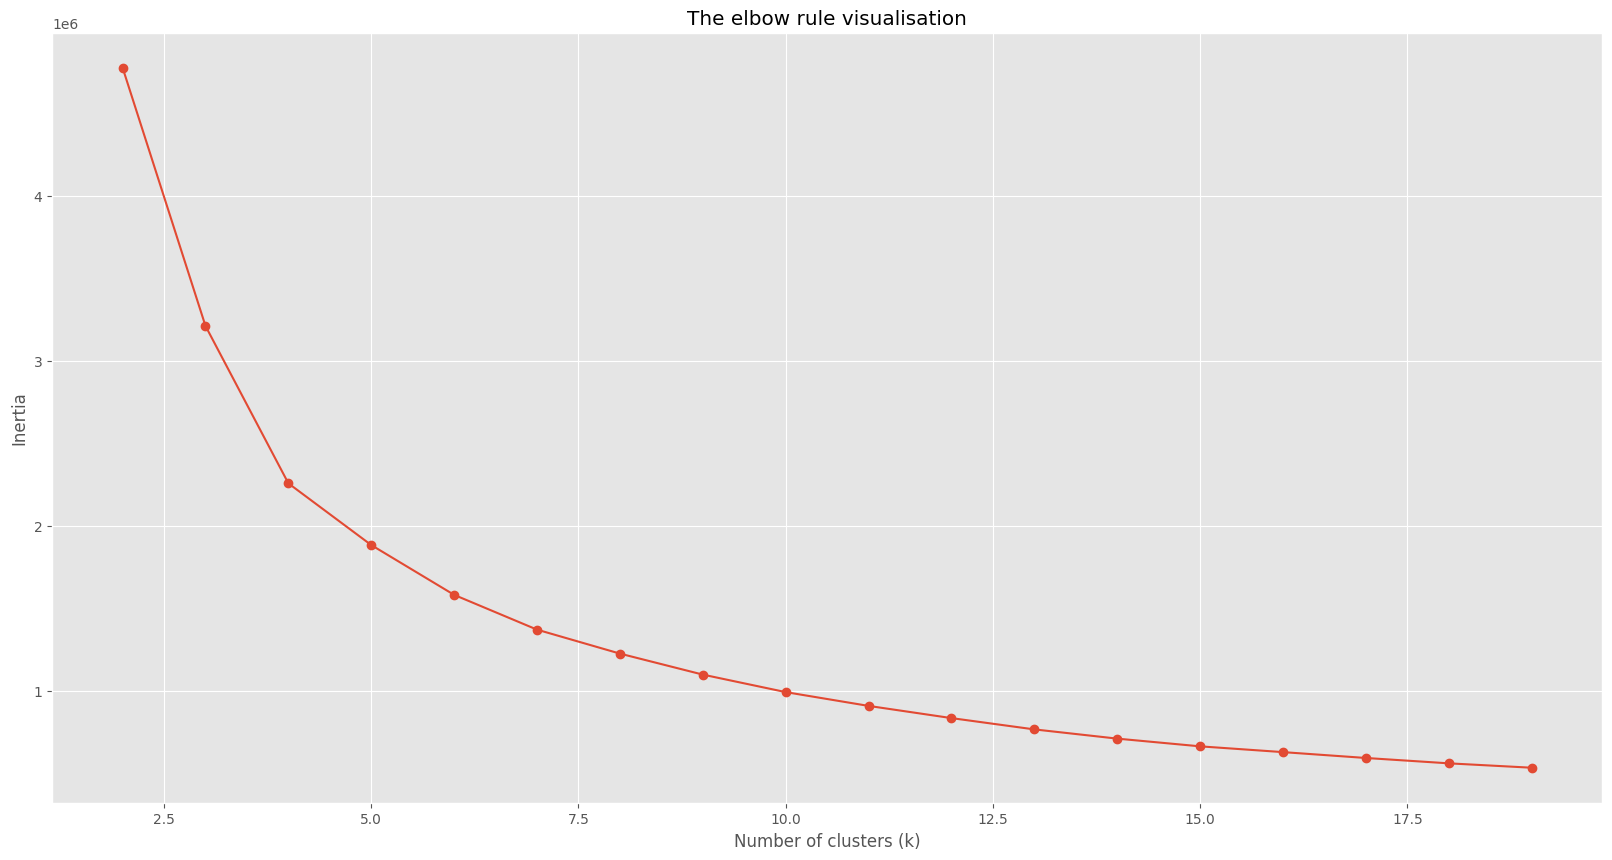

In [ ]:
options = range(2,20)
inertias = []

for n_clusters in options:
    model = KMeans(n_clusters, random_state=42, init='k-means++').fit(x)
    inertias.append(model.inertia_)

plt.figure(figsize=(20,10))
plt.title("The elbow rule visualisation")
plt.plot(options, inertias, '-o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia');

In [ ]:
x

In [ ]:
kmeans.predict(x)